In [1]:
import pickle

res = []

In [ ]:


zestwa = ["1050","1051","1052","1053","1054","1055"]


for z in zestwa:
    print(z)
    with open(f"/home/mgorski/mglab/data/ffs_wyniki_{z}.pkl", "rb") as f:
        res_tmp = pickle.load(f)
    res.extend(res_tmp)

1050
1051
1052
1053
1054
1055


In [4]:
for r in res[:1]:
    print(r.keys())
    print(r["stats"].keys())
    print(r["segments"].keys())
    print(r["stats"]["stars"].keys())


dict_keys(['name', 'hdr', 'stats', 'segments', 'sun_sep', 'moon_sep', 'sun_alt', 'moon_alt', 'moon_ph'])
dict_keys(['min', 'max', 'mean', 'median', 'rms', 'q_sigma_lower', 'q_sigma_upper', 'q_sigma', 'noise', 'bkg_max_amplitude', 'bkg_frame_gradient', 'sky_surface_coeff', 'sky', 'stars', 'lines'])
dict_keys(['diff_n_stars', 'diff_fwhm', 'diff_ell', 'diff_nc'])
dict_keys(['x', 'y', 'max_adu', 'fwhm_x', 'fwhm_y', 'ellipticity', 'theta', 'cpe'])


In [5]:
# konfiguracja schema

def normalize_header(header):
    out = dict(header)

    for k, v in out.items():
        if isinstance(v, str):
            out[k] = v.strip()
        if v == 'T':
            out[k] = True
        if v == 'F':
            out[k] = False

    return out

SCIENCE_SCHEMA = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "required": [
        "IMAGETYP",
        "MIRR-COV",
        "DOME-SHT",
        "ALT_TEL",
        "EXPTIME",
        "T-CAM",
        "T-CAMSET",
        "TRACKING",
        "RHUM-WS",
        "T-WS",
        "WIND-AVG"
    ],
    "properties": {
        "IMAGETYP": {
            "type": "string",
            "enum": ["science"]
        },

        "MIRR-COV": {
            "type": "integer",
            "enum": [3]                 # open
        },

        "DOME-SHT": {
            "type": "integer",
            "enum": [0, 2]              # open / opening
        },

        "ALT_TEL": {
            "type": "number",
            "minimum": 34
        },

        "EXPTIME": {
            "type": "number",
            "Minimum": 0.5
        },

        "T-CAM": {
            "type": "number",
            "maximum": -58
        },

        "T-CAMSET": {
            "type": "number",
            "enum": [-60.0]
        },

        "READ-MOD": {
            "type": "integer",
            "const": 2
        },

        "GAIN-MOD": {
            "type": "integer",
            "const": 2
        },

        "TRACKING": {
            "type": "boolean",
            "const": True
        },

        "FAN-MIRR": {
            "type": "boolean",
            "const": False
        },

        "FAN-DOME": {
            "type": "boolean",
            "const": False
        },

        "RHUM-WS": {
            "type": "number",
            "maximum": 75
        },

        "T-WS": {
            "type": "number",
            "minimum": 0
        },

        "WIND-AVG": {
            "type": "number",
            "maximum": 15
        }
    },

    "additionalProperties": True
}




In [6]:
# General Filter

saturation = 40000

from jsonschema import validate, ValidationError, Draft7Validator
import numpy as np


for r in res:
    objects_2_ignore = ["NGC2362"]

    if r["hdr"]["OBJECT"] not in objects_2_ignore:

        f = r["name"]

        sc = f+" "
        dqc = False
        txt = ""



        # header
        hdr = normalize_header(r["hdr"])

        validator = Draft7Validator(SCIENCE_SCHEMA)
        for err in validator.iter_errors(hdr):
            dqc = True
            sc = sc + "❌"
            txt = txt + f'❌ {list(err.path)} : {err.message} \n'


        # LINIE

        c = r["stats"]["lines"]["val"]

        if len(c)>0:
            c = c[0]
            if c > 500:
                dqc = True
                sc = sc + "*"
                txt = txt + f'* LINE detected {c} \n'

        # GRADIENT
        c = r["stats"]["bkg_frame_gradient"]
        if c > 100:
            dqc = True
            sc = sc + "*"
            txt = txt + f'* FRAME GRADIENT detected {c} \n'
        c = r["stats"]["bkg_max_amplitude"]
        if c > 100:
            dqc = True
            sc = sc + "*"
            txt = txt + f'* LARGE SKY BACKGROUND CHANGES detected {c} \n'

        # czy sa gwiazdy
        stars = r["stats"]["stars"]
        mk = stars["max_adu"] < saturation

        c = len(np.array(stars["x"])[mk])
        if c < 5:
            dqc = True
            sc = sc + "#"
            txt = txt + f'# NO STARS detected {c} \n'
        else:
            # FWHM
            if "fwhm_x" in stars.keys():
                if len(np.array(stars["fwhm_x"])[mk]) < 10:
                    dqc = True
                    sc = sc + "#"
                    txt = txt + f'# NO FWHM measured {c} \n'
                else:
                    fx = np.nanmedian(np.array(stars["fwhm_x"])[mk])
                    fy = np.nanmedian(np.array(stars["fwhm_y"])[mk])
                    if np.isnan(fx) or np.isnan(fy):
                        dqc = True
                        sc = sc + "*"
                        txt = txt + f'* FWHM: {fx} {fy} \n'
                    else:
                        fwhm = fx+fy / 2
                        if fwhm > 14:                           # TUTEJ
                            dqc = True
                            sc = sc + "*"
                            txt = txt + f'* FWHM: {fwhm:.2f} \n'
            else:
                dqc = True
                sc = sc + "#"
                txt = txt + f'# fwhm ERROR {c} \n'

            # ellipcity
            if "ellipticity" in stars.keys():
                if len(np.array(stars["ellipticity"])[mk]) < 10:
                    dqc = True
                    sc = sc + "#"
                    txt = txt + f'# no EL measured {c} \n'
                else:
                    el = np.nanmedian(np.array(stars["ellipticity"])[mk])
                    if np.isnan(el):
                        dqc = True
                        sc = sc + "*"
                        txt = txt + f'* ellipticity: {el:.2f} \n'
                    else:
                        if el > 0.3:                           # TUTEJ
                            dqc = True
                            sc = sc + "*"
                            txt = txt + f'* ellipticity: {el:.2f} \n'
                        # if el > 0.15:
                        #     dqc = True
                        #     sc = sc + "o"
                        #     txt = txt + f'* ellipticity: {el:2.f} \n'
            else:
                dqc = True
                sc = sc + "#"
                txt = txt + f'# fwhm ERROR {c} \n'

        if dqc:
            print(f'{sc} {r["hdr"]["OBJECT"]}')
            print(txt)


/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63948.fits * V854_Car
* LINE detected 535.0 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_65268.fits ❌ AY_Car
❌ ['ALT_TEL'] : 33.855920965093496 is less than the minimum of 34 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_65337.fits ❌ AY_Car
❌ ['ALT_TEL'] : 33.97838083170638 is less than the minimum of 34 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_65974.fits ❌ XX_Vel
❌ ['FAN-MIRR'] : False was expected 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_69232.fits ** BB_Pup
* FRAME GRADIENT detected 127.04980492788536 
* LARGE SKY BACKGROUND CHANGES detected 137.4138875969677 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_69312.fits ** BB_Pup
* FRAME GRADIENT detected 132.36124459296968 
* LARGE SKY BACKGROUND CHANGES detected 142.7789454489972 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_75697.fits ❌ WX_Pup
❌ ['FAN-MIRR'] : False was expected 

/work/vela/oca/fits/zb08/raw/1051/zb08c_1051_57763.fits ❌ SX_For
❌ ['FAN-MIRR'] : False was ex

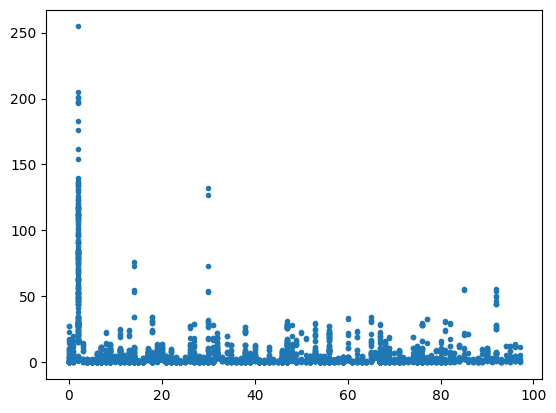

4053 NGC2362 2


In [62]:
# objects to plot

import matplotlib.pyplot as plt
import numpy as np


objects_2_ignore = []

objects = []
objects_n = []
xl = []
yl = []
for r in res:
    ob = r["hdr"]["OBJECT"]
    if ob not in objects:
        objects.append(ob)
        objects_n.append(1)
    else:
        if r["hdr"]["OBJECT"] not in objects_2_ignore:
            objects_n[objects.index(ob)] += 1
            xl.append(objects.index(ob))
            yl.append(r["stats"]["bkg_frame_gradient"])

# r["hdr"]["AZ_TEL"]
#y = r["hdr"]["ALT_TEL"]
#c = r["stats"]["bkg_frame_gradient"]
#c = r["stats"]["bkg_max_amplitude"]

fig, ax = plt.subplots()
#c = ax.scatter(th,r,c=val, s=50,alpha=0.5)
c = ax.plot(xl,yl,".")

#c2 = ax.plot(xl[4053],yl[4053],"ro")
#fig.colorbar(c, ax=ax)

plt.show()

ii = np.argmax(yl)
i = xl[ii]

print(ii,objects[i],xl[ii])


In [63]:
# data do plot


objects = []
objects_n = []

for r in res:
    ob = r["hdr"]["OBJECT"]
    if ob not in objects:
        objects.append(ob)
        objects_n.append(1)
    else:
        objects_n[objects.index(ob)] += 1

    if r["hdr"]["OBJECT"] not in objects_2_ignore:
        y = r["stats"]["bkg_frame_gradient"]
        x = r["hdr"]["ALT_TEL"]


        xl.append(x)
        yl.append(y)

# r["hdr"]["AZ_TEL"]
#y = r["hdr"]["ALT_TEL"]
#c = r["stats"]["bkg_frame_gradient"]
#c = r["stats"]["bkg_max_amplitude"]



print(len(cl))
#print(cl)

1043


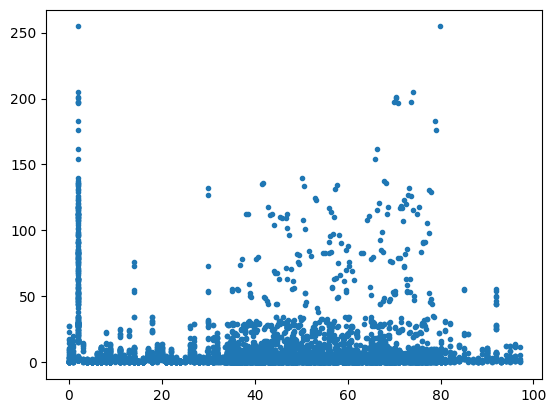

In [64]:
import matplotlib.pyplot as plt
import numpy as np




fig, ax = plt.subplots()
#c = ax.scatter(th,r,c=val, s=50,alpha=0.5)
c = ax.plot(xl,yl,".")



#fig.colorbar(c, ax=ax)

plt.show()

In [65]:
# data do plot

objects_2_ignore = ["NGC2362",]
cl = []
xl = []
yl = []
for r in res:
    c = r["stats"]["bkg_frame_gradient"]
    if r["hdr"]["OBJECT"] not in objects_2_ignore:
        c = c
        x = r["hdr"]["AZ_TEL"]
        y = r["hdr"]["ALT_TEL"]
        if c > 5:
            #print(r["name"],r["hdr"]["OBJECT"],r["segments"]["diff_fwhm"],r["segments"]["diff_ell"])
            cl.append(c)
            xl.append(x)
            yl.append(y)


#c = r["stats"]["bkg_frame_gradient"]
#c = r["stats"]["bkg_max_amplitude"]



print(len(cl))
print(cl)


1043
[np.float64(5.385973416542413), np.float64(10.442908330665148), np.float64(6.494530506361457), np.float64(11.784057481309503), np.float64(10.68273288635828), np.float64(10.771290104664274), np.float64(14.654492460961023), np.float64(14.251885973467097), np.float64(5.387220761983883), np.float64(5.154652787765542), np.float64(9.19102612440139), np.float64(9.487767371247514), np.float64(6.930513881779973), np.float64(6.545116276149315), np.float64(7.972413382451293), np.float64(7.54619599000273), np.float64(5.380862235306779), np.float64(5.488919136878792), np.float64(5.369442869576403), np.float64(5.644905726920172), np.float64(10.178230317558985), np.float64(10.19697345228343), np.float64(8.241661734145566), np.float64(8.342245346756272), np.float64(8.282530422920786), np.float64(7.895288713590958), np.float64(9.064425199700963), np.float64(9.561870553654046), np.float64(7.519172124042768), np.float64(7.540788251703532), np.float64(7.827048447611787), np.float64(7.804484509867564)

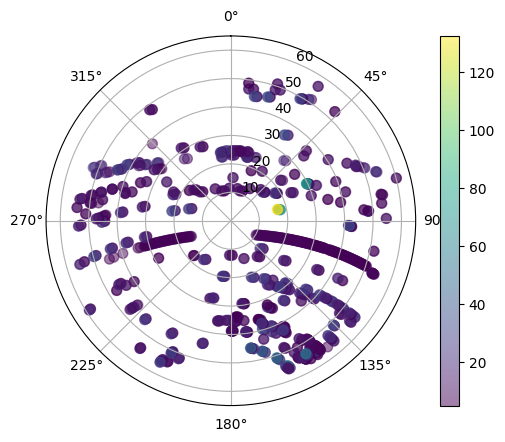

In [66]:



th = np.radians(xl)
r = 90 - np.array(yl)
val = np.array(cl)

fig, ax = plt.subplots(subplot_kw={"projection":"polar"})
c = ax.scatter(th,r,c=val, s=50,alpha=0.5)


ax.set_ylim(0,65)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

fig.colorbar(c, ax=ax)

plt.show()